In [1]:
!pip install casadi pymoo --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 4.0 MB/s eta 0:00:00


In [2]:
import casadi as ca
import numpy as np
from scipy.linalg import svd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import interp1d
import time
import pandas as pd
from scipy.optimize import least_squares
import pandas as pd
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.core.sampling import Sampling
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

## Data

In [3]:
data_file = 'ssf_25_999.txt'
df = pd.read_csv(data_file, sep='\s+', header=None)
df.columns = ["Time_h", "Urea", "Biomass", "CO2", "O2", "GA3", "Starch"]
df = df.astype(float)

t_exp = df["Time_h"].to_numpy()
t_exp_shifted = t_exp - t_exp[0]  # Mover t=20 → t=0
exp_data = df[["Urea", "Biomass", "CO2", "O2", "GA3", "Starch"]].to_numpy()

##Model Definition

In [4]:
nx = 8
nth = 14
observed_indices = [1, 3, 4, 5, 6, 7]
ny = len(observed_indices)

theta_nom = np.array([
    0.3, 0.05, 5e-3, 0.2, 0.1, 0.0,
    16.0, 3e-3, 3.3, 17.0, 6e-4, 2e3,
    0.17, 0.05
])

Tf = 120
Nt = 101
t_eval = np.linspace(0, Tf, Nt)

u0 = 3.146 / 1000
s0 = 1.768685 / 10
x0_val = np.array([0.006878, u0, 0, 0.006878, 0.00885, 0.00467, 0, s0])

y_exp_interp = np.zeros((Nt, ny))
for j in range(ny):
    y_exp_interp[:, j] = np.interp(t_eval, t_exp_shifted, exp_data[:, j])

In [5]:
# === Dynamic fermentation model ===
def model_rhs(t, x, theta):
    mun, kd, ku, mco2, mo2, kp, yxn, kn, yxco2, yxo2, betam, ki, yxs, ms = theta
    mu = mun * x[2] / (kn + x[2]) if kn + x[2] != 0 else 0
    beta = betam / (1 + ki * x[2]) if 1 + ki * x[2] != 0 else 0
    dx = np.zeros(8)
    dx[0] = mu * x[0] - kd * x[0]
    dx[1] = -ku if x[1] > 0 else 0
    dx[2] = 0.47 * ku - mu * x[0] / yxn if x[1] > 0 else - mu * x[0] / yxn
    dx[3] = mu * x[0]
    dx[4] = mu * x[0] / yxco2 + mco2 * x[0]
    dx[5] = mu * x[0] / yxo2 + mo2 * x[0]
    dx[6] = beta * x[0] - kp * x[6]
    dx[7] = -mu * x[0] / yxs - ms * x[0]
    return dx

##T-values: manual fix function

In [6]:
# === Residue function ===
def residuals(theta_free, theta_nom, free_idx):
    theta_full = theta_nom.copy()
    theta_full[free_idx] = theta_free
    try:
        sol = solve_ivp(lambda t, x: model_rhs(t, x, theta_full),
                        (0, Tf), x0_val, t_eval=t_eval,
                        method='RK45', rtol=1e-6, atol=1e-8)
        x_out = sol.y.T
        y_model = x_out[:, observed_indices]
        return (y_model - y_exp_interp).flatten()
    except Exception:
        return np.ones(Nt * ny) * 1e6

# === Analysis of t-values: preliminar ===
def run_t_value_analysis_fixed(fixed_idx, theta_nom, bounds, n_iter):
    free_idx = [i for i in range(len(theta_nom)) if i not in fixed_idx]
    bounds_free = (bounds[0][free_idx], bounds[1][free_idx])
    t_values_all = []

    for i in range(n_iter):
        theta_init = np.random.uniform(*bounds_free)
        try:
            res = least_squares(
                residuals, theta_init,
                args=(theta_nom, free_idx),
                bounds=bounds_free, jac='3-point'
            )
            J = res.jac
            dof = len(res.fun) - np.linalg.matrix_rank(J)
            sigma2 = np.sum(res.fun**2) / dof
            Cov = sigma2 * np.linalg.pinv(J.T @ J)
            std_theta = np.sqrt(np.diag(Cov))
            t_vals = res.x / std_theta
            t_values_all.append(t_vals)
        except Exception:
            continue

    t_values_all = np.array(t_values_all)
    t_avg = np.mean(t_values_all, axis=0)
    t_std = np.std(t_values_all, axis=0)
    return {
        "free_idx": free_idx,
        "t_values_all": t_values_all,
        "t_avg": t_avg,
        "t_std": t_std
    }

##Monte Carlo and preliminar t value analysis

In [24]:
n_iter=100
theta_low = 0.9 * theta_nom
theta_high = 1.1 * theta_nom
fixed_idx = [5]  # θ6
result = run_t_value_analysis_fixed(fixed_idx, theta_nom, (theta_low, theta_high), n_iter)

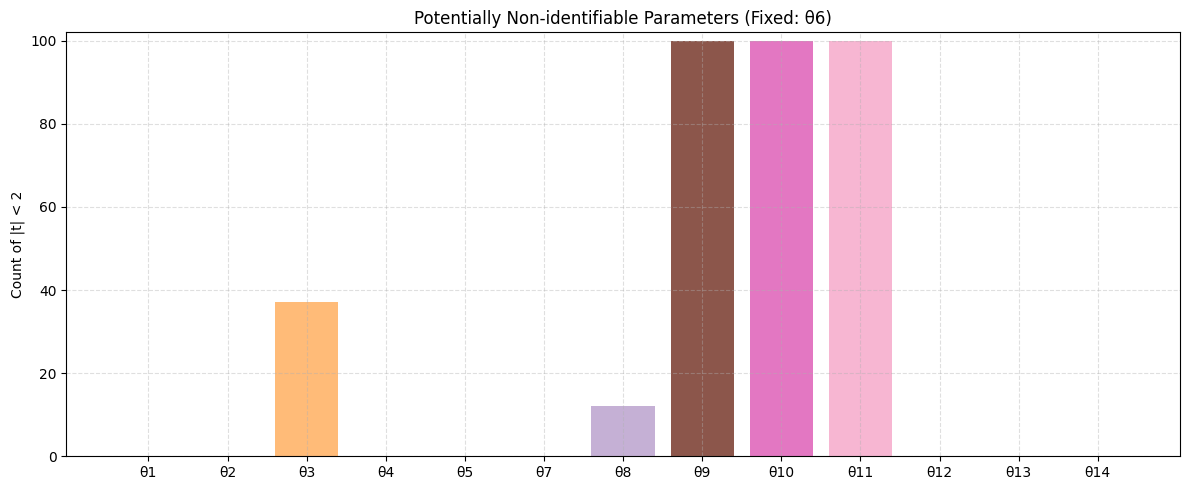

In [13]:
# === 9. Plot of all free parameters with distinct colors ===
t_vals_all = result["t_values_all"]
free_idx = result["free_idx"]
n_iter = t_vals_all.shape[0]
threshold = 2

# Count how many times |t| < threshold for each parameter
non_identifiable_counts = np.sum(np.abs(t_vals_all) < threshold, axis=0)
param_labels = [f"θ{i+1}" for i in free_idx]

# Generate N distinct colors from the 'tab20' colormap
cmap = plt.colormaps['tab20']
colors = [cmap(i / len(free_idx)) for i in range(len(free_idx))]

# Create bar plot
plt.figure(figsize=(12, 5))
bars = plt.bar(param_labels, non_identifiable_counts, color=colors)

plt.ylabel("Count of |t| < 2")
plt.title("Potentially Non-identifiable Parameters (Fixed: " + ", ".join(f"θ{i+1}" for i in fixed_idx) + ")")
plt.ylim(0, n_iter + 2)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [8]:
from itertools import combinations
import numpy as np

def hierarchical_identifiability_search(
    fixed_base,
    theta_nom,
    bounds,
    n_iter=100,
    threshold=2.0,
    max_additional_fixed=4,
    max_combinations=20,
    verbose=True
):
    """
    Search for minimal set of parameters to fix so that all remaining ones
    become practically identifiable based on t-value analysis.
    """
    nth = len(theta_nom)
    results_log = []
    combination_counter = 0

    # Step 1: Run t-value analysis with only the fixed base
    result_base = run_t_value_analysis_fixed(fixed_base, theta_nom, bounds, n_iter)
    tvals_base = result_base["t_values_all"]
    free_idx_base = result_base["free_idx"]

    # Step 2: Rank remaining parameters by how often they fail (t < threshold)
    fail_counts = np.sum(np.abs(tvals_base) < threshold, axis=0)
    param_ranking = [free_idx_base[i] for i in np.argsort(-fail_counts) if fail_counts[i] > 0]

    best_combination = None
    best_result = None

    for k in range(1, max_additional_fixed + 1):
        for added in combinations(param_ranking, k):
            if combination_counter >= max_combinations:
                if verbose:
                    print("Reached maximum number of combinations.")
                break

            fixed_comb = sorted(fixed_base + list(added))
            result = run_t_value_analysis_fixed(fixed_comb, theta_nom, bounds, n_iter)
            tvals = result["t_values_all"]
            t_avg = np.mean(tvals, axis=0)
            t_sum = np.sum(np.abs(t_avg))
            mask = [0 if i in fixed_comb else 1 for i in range(nth)]

            results_log.append({
                "mask": mask,
                "t_all": tvals
            })

            if verbose:
                print(f"Fix {', '.join(f'θ{i+1}' for i in fixed_comb)} → total |t| sum = {t_sum:.2f}")

            combination_counter += 1

            if np.all(np.abs(t_avg) > threshold):
                best_combination = fixed_comb
                best_result = result
                break
        else:
            continue
        break

    return {
        "best_fixed": best_combination,
        "best_result": best_result,
        "log": results_log,
        "base_result": result_base
    }

In [9]:
res = hierarchical_identifiability_search(
    fixed_base=[5],
    theta_nom=theta_nom,
    bounds=(theta_low, theta_high),
    n_iter=10,
    threshold=2.0,
    max_additional_fixed=4,
    max_combinations=20
)

print("Best fixed set:", res["best_fixed"])

Fix θ6, θ9 → total |t| sum = 448190808.50
Fix θ6, θ10 → total |t| sum = 11576229428.91
Fix θ6, θ11 → total |t| sum = 457901.53
Fix θ3, θ6 → total |t| sum = 46494544.56
Fix θ6, θ8 → total |t| sum = 14634479.56
Fix θ6, θ9, θ10 → total |t| sum = 5180699439.81
Fix θ6, θ9, θ11 → total |t| sum = 3191617.38
Fix θ3, θ6, θ9 → total |t| sum = 91235211.21
Fix θ6, θ8, θ9 → total |t| sum = 109561093.62
Fix θ6, θ10, θ11 → total |t| sum = 304649468.20
Fix θ3, θ6, θ10 → total |t| sum = 2561231924.73
Fix θ6, θ8, θ10 → total |t| sum = 3771792034.59
Fix θ3, θ6, θ11 → total |t| sum = 609834.92
Fix θ6, θ8, θ11 → total |t| sum = 640184.40
Fix θ3, θ6, θ8 → total |t| sum = 1747993.80
Fix θ6, θ9, θ10, θ11 → total |t| sum = 3036569932.80
Best fixed set: [5, 8, 9, 10]


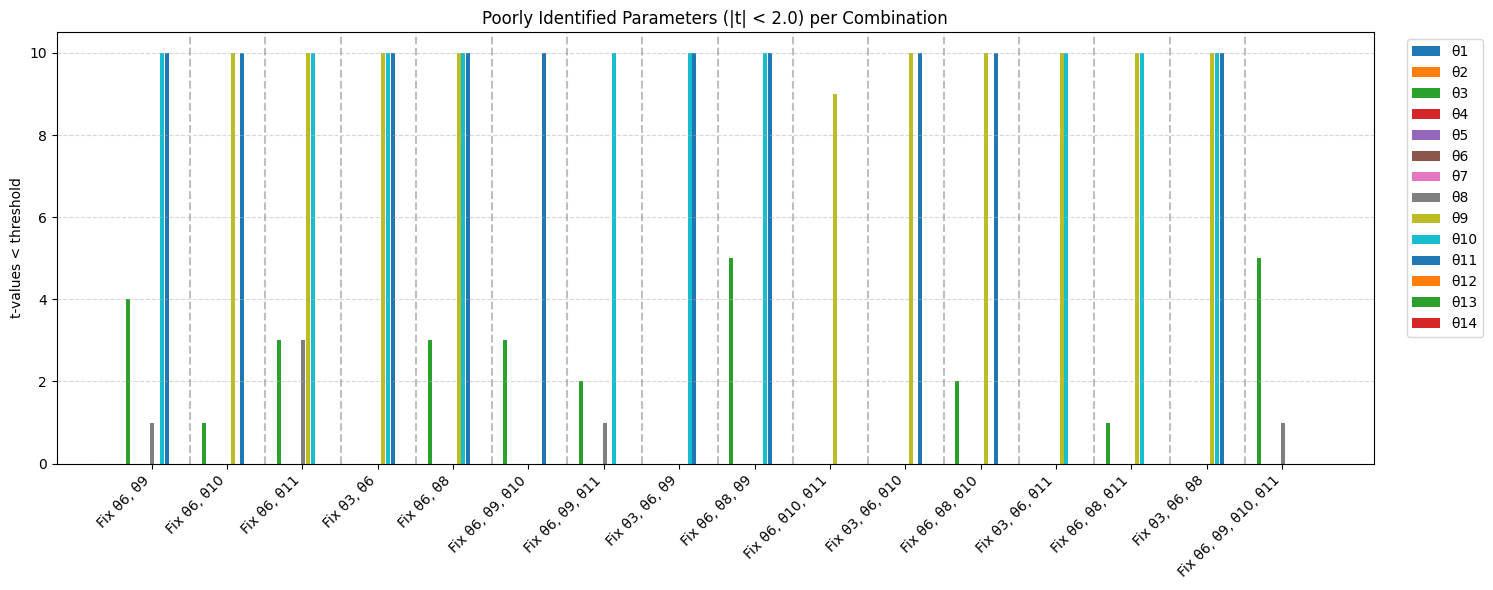

In [11]:
# === Run Monte Carlo t-value analysis ===
def plot_problematic_tvalues(results_log, threshold=2.0):

    param_labels = [f"θ{i+1}" for i in range(nth)]
    combinations_labels = []
    all_counts = []

    for entry in results_log:
        mask = np.array(entry["mask"]).astype(bool)
        free_idx = [i for i in range(len(mask)) if mask[i]]
        t_vals_all = entry["t_all"]

        count_row = np.zeros(nth, dtype=int)
        for i, idx in enumerate(free_idx):
            bad_count = np.sum(np.abs(t_vals_all[:, i]) < threshold)
            count_row[idx] = bad_count

        all_counts.append(count_row)
        combinations_labels.append("Fix " + ", ".join(f"θ{i+1}" for i in range(nth) if not mask[i]))

    all_counts = np.array(all_counts)

    # === Plotting with vertical dividers ===
    fig, ax = plt.subplots(figsize=(15, 6))

    bar_width = 0.05
    gap = 0.01  # reduced spacing
    group_width = nth * (bar_width + gap)
    total_combinations = len(combinations_labels)
    x_base = np.arange(total_combinations) * (group_width + 0.1)  # tighter layout

    for i in range(nth):
        bar_positions = x_base + i * (bar_width + gap)
        ax.bar(bar_positions, all_counts[:, i], bar_width, label=param_labels[i])

    # Add vertical dashed lines between combinations
    for xpos in x_base[1:]:
        ax.axvline(x=xpos - 0.05, linestyle='--', color='gray', alpha=0.5)

    # Set ticks in the center of each group
    ax.set_xticks(x_base + group_width / 2 - gap)
    ax.set_xticklabels(combinations_labels, rotation=45, ha='right')

    ax.set_ylabel("t-values < threshold")
    ax.set_title("Poorly Identified Parameters (|t| < {:.1f}) per Combination".format(threshold))
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
# Step 5: plot results
threshold = 2
plot_problematic_tvalues(res["log"], threshold=threshold)

In [23]:
# === 1. Define names of parameters ===

param_names = [f"θ{i+1}" for i in range(14)]
n_params = len(param_names)

# === 2. Extract info from log ===
combo_labels = []
all_tvals = []

for entry in res["log"]:
    mask = entry["mask"]
    t_vals_all = entry["t_all"]

    fixed_idx = [i for i, m in enumerate(mask) if m == 0]
    free_idx = [i for i, m in enumerate(mask) if m == 1]

    label = ", ".join(param_names[i] for i in fixed_idx) if fixed_idx else "None fixed"
    combo_labels.append(label)

    col_vals = []
    for j in range(n_params):
        if j in free_idx and t_vals_all.shape[0] > 0:
            pos = free_idx.index(j)
            col_vals.append(np.mean(np.abs(t_vals_all[:, pos])))
        else:
            col_vals.append(np.nan)
    all_tvals.append(col_vals)

# === 3. Create DataFrame ===
df = pd.DataFrame(np.array(all_tvals).T, index=param_names, columns=combo_labels)

# === 4. Add row with total t-value sum per combination ===
df.loc["sum t values"] = df.apply(np.nansum, axis=0)

# === 5. Cell coloring rules ===
threshold = 2.0
def color_map_body(val):
    if np.isnan(val):
        return 'background-color: #e0e0e0'
    elif val < threshold:
        return 'background-color: salmon'
    else:
        return 'background-color: lightgreen'

def highlight_sum_row(row):
    if row.name == "sum t values":
        return [
            'border-top: 3px solid black; background-color: #f6f6f6; font-weight: bold;'
            for _ in row
        ]
    else:
        return ['' for _ in row]

cell_borders = [
    {'selector': 'td', 'props': 'border: 1px solid #aaa; font-size:10pt; padding:2px;'},
    {'selector': 'th', 'props': 'border: 1px solid #aaa; font-size:11pt; padding:3px;'},
    {'selector': 'tr', 'props': [("line-height", "1.0")]}
]

# === 6. Display styled table ===
df_style = (
    df.style
      .format("{:.2e}")
      .map(color_map_body, subset=pd.IndexSlice[param_names, :])
      .apply(highlight_sum_row, axis=1)
      .set_table_styles(cell_borders)
      .set_properties(**{'font-size': '10pt', 'padding': '2px'})
)

df_style

,"θ6, θ9","θ6, θ10","θ6, θ11","θ3, θ6","θ6, θ8","θ6, θ9, θ10","θ6, θ9, θ11","θ3, θ6, θ9","θ6, θ8, θ9","θ6, θ10, θ11","θ3, θ6, θ10","θ6, θ8, θ10","θ3, θ6, θ11","θ6, θ8, θ11","θ3, θ6, θ8","θ6, θ9, θ10, θ11"
θ1,3.94e+00,4.11e+00,3.65e+00,4.45e+00,1.86e+01,5.61e+00,4.00e+00,8.36e+00,1.93e+01,4.17e+00,2.59e+01,1.46e+01,1.26e+01,1.60e+01,4.20e+01,1.30e+01
θ2,2.36e+01,2.09e+01,1.58e+01,1.71e+01,1.81e+01,2.41e+01,2.36e+01,2.86e+01,2.94e+01,2.07e+01,2.14e+01,2.43e+01,1.81e+01,1.90e+01,1.97e+01,2.38e+01
θ3,3.77e+00,6.39e+00,5.06e+00,nan,4.39e+00,3.69e+00,4.22e+00,nan,4.24e+00,6.94e+00,nan,3.08e+00,nan,6.82e+00,nan,3.72e+00
θ4,2.76e+01,1.64e+01,1.14e+01,1.22e+01,1.20e+01,2.83e+01,2.78e+01,3.37e+01,3.31e+01,1.62e+01,1.65e+01,1.74e+01,1.26e+01,1.27e+01,1.31e+01,2.78e+01
θ5,1.72e+01,2.47e+01,1.06e+01,1.13e+01,1.12e+01,2.79e+01,1.73e+01,1.93e+01,1.90e+01,2.45e+01,2.52e+01,2.78e+01,1.17e+01,1.17e+01,1.21e+01,2.75e+01
θ6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
θ7,1.25e+01,1.12e+01,1.26e+01,3.09e+01,1.47e+01,1.10e+01,1.38e+01,2.02e+01,1.73e+01,1.09e+01,2.40e+01,1.14e+01,2.06e+01,1.23e+01,4.40e+01,1.30e+01
θ8,2.76e+00,2.87e+00,2.57e+00,3.44e+00,nan,3.25e+00,2.70e+00,4.86e+00,nan,2.83e+00,4.27e+00,nan,6.28e+00,nan,nan,3.46e+00
θ9,nan,1.84e+00,1.34e+00,1.34e+00,1.30e+00,nan,nan,nan,nan,1.85e+00,1.81e+00,1.87e+00,1.37e+00,1.37e+00,1.36e+00,nan
θ10,6.17e-01,nan,4.42e-01,4.54e-01,4.39e-01,nan,6.16e-01,6.23e-01,6.22e-01,nan,nan,nan,4.61e-01,4.57e-01,4.60e-01,nan
